In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd /content/drive/MyDrive/bda
!ls

drive  sample_data  vgg16_model.h5


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
data = pd.read_csv("/content/drive/MyDrive/bda/metadata_processed.csv")

<Axes: xlabel='emotion', ylabel='count'>

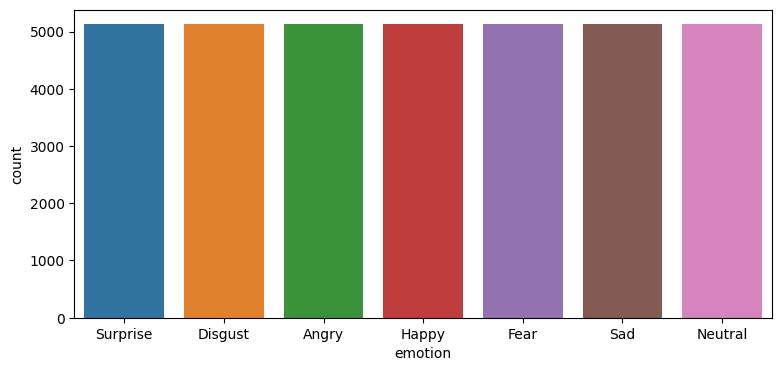

In [5]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=data)

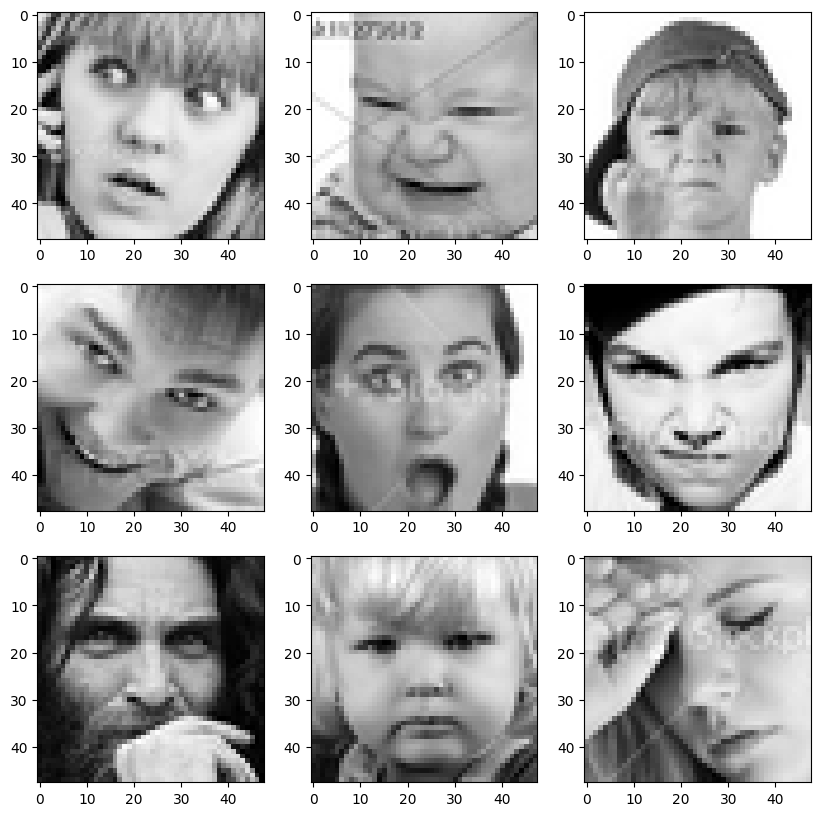

In [6]:
labels = data.iloc[:, 0]
pixels = data.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])
plt.figure(figsize = (10,10))
for index,image in enumerate(images[:9]):
    plt.subplot(3,3,index+1)
    plt.imshow(image.reshape((48,48)), cmap = 'gray')
plt.show()
train_or_test = data.iloc[:, 2].values

In [7]:
data['emotion'].unique()

array(['Surprise', 'Disgust', 'Angry', 'Happy', 'Fear', 'Sad', 'Neutral'],
      dtype=object)

In [8]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1
reshaped_images.shape

(35882, 48, 48, 1)

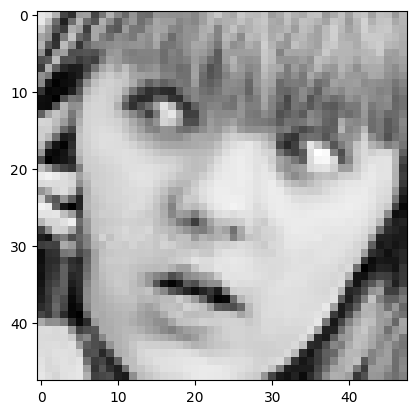

In [9]:
norm_images = reshaped_images / 255.0
plt.imshow(norm_images[0].reshape((48,48)), cmap="gray")
plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical
new_labels = to_categorical(labels, num_classes=7)
new_labels.shape

(35882, 7)

In [11]:
reshaped_images.shape

(35882, 48, 48, 1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28705, 48, 48, 1), (7177, 48, 48, 1), (28705, 7), (7177, 7))

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Repeat the single channel to create three channels
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Load the VGG16 model with the input shape (48, 48, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the weights of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Build the custom layers
model = Flatten()(base_model.output)
model = Dense(64)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Dropout(0.35)(model)
model = Dense(128)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Dropout(0.35)(model)
model = Dense(256)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Dropout(0.35)(model)
model = Dense(512)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Dropout(0.35)(model)
model = Dense(7, activation='softmax')(model)

# Create the full model
full_model = Model(inputs=base_model.input, outputs=model)

# Compile the model with an appropriate optimizer, loss, and metrics
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("vgg16_model.h5", monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, mode='min')
callbacks = [checkpoint, reduce_lr]

# Train the model
epochs = 50 # Set the number of epochs as needed
from tensorflow.keras.preprocessing.image import ImageDataGenerator



history = full_model.fit(X_train_rgb, y_train, batch_size=32,
                         validation_data=(X_test_rgb, y_test),
                         callbacks=callbacks,
                         epochs=epochs)


Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.9913 - accuracy: 0.2342
Epoch 1: saving model to vgg16_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 32s 25ms/step - loss: 1.9913 - accuracy: 0.2342 - val_loss: 1.6945 - val_accuracy: 0.3416 - lr: 0.0010
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 1.7492 - accuracy: 0.3197
Epoch 2: saving model to vgg16_model.h5
898/898 [==============================] - 19s 21ms/step - loss: 1.7492 - accuracy: 0.3197 - val_loss: 1.5876 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.6654 - accuracy: 0.3566
Epoch 3: saving model to vgg16_model.h5
898/898 [==============================] - 17s 19ms/step - loss: 1.6654 - accuracy: 0.3566 - val_loss: 1.5323 - val_accuracy: 0.4059 - lr: 0.0010
Epoch 4/50
896/898 [============================>.] - ETA: 0s - loss: 1.6118 - accuracy: 0.3821
Epoch 4: saving model to vgg16_model.h5
898/898 [==============================] - 17s 19ms/step - loss: 1.6119 - accuracy: 0.3820 - val_loss: 1.4914 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 5/

In [14]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

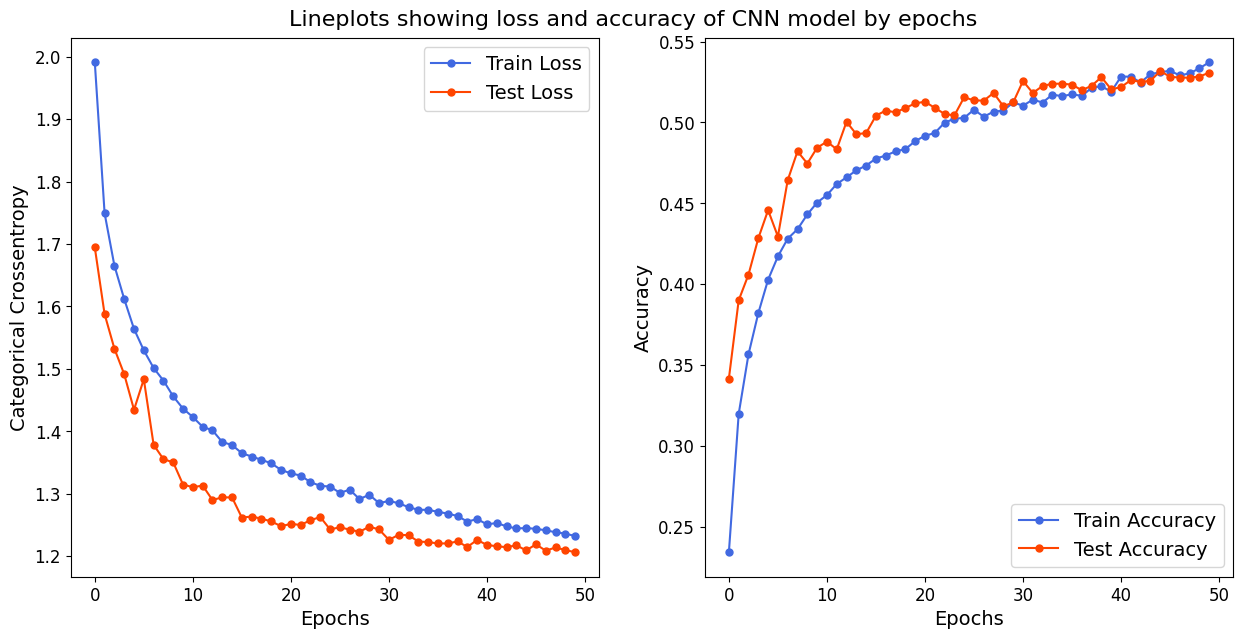

In [15]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)